# <span style="color:slateblue"><b>Import Dependencies

In [1]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import scipy.stats as sp
import itertools
import pickle

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import sklearn as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# <span style="color:slateblue"><b>Data Load</span>

In [2]:
# file paths
file_path_Raw = "./Resources/cumulative.csv"
file_path_Pickles = "./Pickles/"

In [3]:
# Load dataset
keplerRAW_df = pd.read_csv(file_path_Raw)
keplerRAW_df

rowid     kepid kepoi_name   kepler_name koi_disposition  \
0         1  10797460  K00752.01  Kepler-227 b       CONFIRMED   
1         2  10797460  K00752.02  Kepler-227 c       CONFIRMED   
2         3  10811496  K00753.01           NaN  FALSE POSITIVE   
3         4  10848459  K00754.01           NaN  FALSE POSITIVE   
4         5  10854555  K00755.01  Kepler-664 b       CONFIRMED   
...     ...       ...        ...           ...             ...   
9559   9560  10031643  K07984.01           NaN  FALSE POSITIVE   
9560   9561  10090151  K07985.01           NaN  FALSE POSITIVE   
9561   9562  10128825  K07986.01           NaN       CANDIDATE   
9562   9563  10147276  K07987.01           NaN  FALSE POSITIVE   
9563   9564  10156110  K07989.01           NaN  FALSE POSITIVE   

     koi_pdisposition  koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
0           CANDIDATE      1.000              0              0              0   
1           CANDIDATE      0.969              0              0              0   
2      FALSE POSITIVE      0.000              0              1              0   
3      FALSE POSITIVE      0.000              0              1              0   
4           CANDIDATE      1.000              0              0              0   
...               ...        ...            ...            ...            ...   
9559   FALSE POSITIVE      0.000              0              0              0   
9560   FALSE POSITIVE      0.000              0              1              1   
9561        CANDIDATE      0.497              0              0              0   
9562   FALSE POSITIVE      0.021              0              0              1   
9563   FALSE POSITIVE      0.000              0              0              1   

      ...  koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  \
0     ...           -81.0      4.467           0.064          -0.096   
1     ...           -81.0      4.467           0.064          -0.096   
2     ...          -176.0      4.544           0.044          -0.176   
3     ...          -174.0      4.564           0.053          -0.168   
4     ...          -211.0      4.438           0.070          -0.210   
...   ...             ...        ...             ...             ...   
9559  ...          -152.0      4.296           0.231          -0.189   
9560  ...          -166.0      4.529           0.035          -0.196   
9561  ...          -220.0      4.444           0.056          -0.224   
9562  ...          -236.0      4.447           0.056          -0.224   
9563  ...          -225.0      4.385           0.054          -0.216   

      koi_srad  koi_srad_err1  koi_srad_err2         ra        dec  koi_kepmag  
0        0.927          0.105         -0.061  291.93423  48.141651      15.347  
1        0.927          0.105         -0.061  291.93423  48.141651      15.347  
2        0.868          0.233         -0.078  297.00482  48.134129      15.436  
3        0.791          0.201         -0.067  285.53461  48.285210      15.597  
4        1.046          0.334         -0.133  288.75488  48.226200      15.509  
...        ...            ...            ...        ...        ...         ...  
9559     1.088          0.313         -0.228  298.74921  46.973351      14.478  
9560     0.903          0.237         -0.079  297.18875  47.093819      14.082  
9561     1.031          0.341         -0.114  286.50937  47.163219      14.757  
9562     1.041          0.341         -0.114  294.16489  47.176281      15.385  
9563     1.193          0.410         -0.137  297.00977  47.121021      14.826  

[9564 rows x 50 columns]

In [4]:
with open(file_path_Pickles+'kepler_RAW.pkl', 'wb') as pickle_file:
    pickle.dump(keplerRAW_df, pickle_file)

# <span style="color:slateblue"><b>CLEANING & EDA

In [5]:
keplerRAW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [6]:
keplerRAW_df.describe()

rowid         kepid    koi_score  koi_fpflag_nt  koi_fpflag_ss  \
count  9564.000000  9.564000e+03  8054.000000    9564.000000    9564.000000   
mean   4782.500000  7.690628e+06     0.480829       0.188206       0.231598   
std    2761.033321  2.653459e+06     0.476928       0.390897       0.421875   
min       1.000000  7.574500e+05     0.000000       0.000000       0.000000   
25%    2391.750000  5.556034e+06     0.000000       0.000000       0.000000   
50%    4782.500000  7.906892e+06     0.334000       0.000000       0.000000   
75%    7173.250000  9.873066e+06     0.998000       0.000000       0.000000   
max    9564.000000  1.293514e+07     1.000000       1.000000       1.000000   

       koi_fpflag_co  koi_fpflag_ec     koi_period  koi_period_err1  \
count    9564.000000    9564.000000    9564.000000      9110.000000   
mean        0.194898       0.120033      75.671358         0.002148   
std         0.396143       0.325018    1334.744046         0.008236   
min         0.000000       0.000000       0.241843         0.000000   
25%         0.000000       0.000000       2.733684         0.000005   
50%         0.000000       0.000000       9.752831         0.000035   
75%         0.000000       0.000000      40.715178         0.000276   
max         1.000000       1.000000  129995.778400         0.172500   

       koi_period_err2  ...  koi_steff_err2    koi_slogg  koi_slogg_err1  \
count      9110.000000  ...     9081.000000  9201.000000     9096.000000   
mean         -0.002148  ...     -162.265059     4.310157        0.120738   
std           0.008236  ...       72.746348     0.432606        0.132837   
min          -0.172500  ...    -1762.000000     0.047000        0.000000   
25%          -0.000276  ...     -198.000000     4.218000        0.042000   
50%          -0.000035  ...     -160.000000     4.438000        0.070000   
75%          -0.000005  ...     -114.000000     4.543000        0.149000   
max           0.000000  ...        0.000000     5.364000        1.472000   

       koi_slogg_err2     koi_srad  koi_srad_err1  koi_srad_err2           ra  \
count     9096.000000  9201.000000    9096.000000    9096.000000  9564.000000   
mean        -0.143161     1.728712       0.362292      -0.394806   292.060163   
std          0.085477     6.127185       0.930870       2.168213     4.766657   
min         -1.207000     0.109000       0.000000    -116.137000   279.852720   
25%         -0.196000     0.829000       0.129000      -0.250000   288.660770   
50%         -0.128000     1.000000       0.251000      -0.111000   292.261125   
75%         -0.088000     1.345000       0.364000      -0.069000   295.859160   
max          0.000000   229.908000      33.091000       0.000000   301.720760   

               dec   koi_kepmag  
count  9564.000000  9563.000000  
mean     43.810433    14.264606  
std       3.601243     1.385448  
min      36.577381     6.966000  
25%      40.777173    13.440000  
50%      43.677504    14.520000  
75%      46.714611    15.322000  
max      52.336010    20.003000  

[8 rows x 45 columns]

In [7]:
# The default index adds no value, however the "kepoi_name" is the unique identifier for each object of interest (row).
# We make this the index to preserve relationships through the processing

# change the index to the "kepoi_name" and drop the index title
keplerProcessed_df = keplerRAW_df.set_index('kepoi_name')
keplerProcessed_df.rename_axis(None, inplace=True)

keplerProcessed_df 

rowid     kepid   kepler_name koi_disposition koi_pdisposition  \
K00752.01      1  10797460  Kepler-227 b       CONFIRMED        CANDIDATE   
K00752.02      2  10797460  Kepler-227 c       CONFIRMED        CANDIDATE   
K00753.01      3  10811496           NaN  FALSE POSITIVE   FALSE POSITIVE   
K00754.01      4  10848459           NaN  FALSE POSITIVE   FALSE POSITIVE   
K00755.01      5  10854555  Kepler-664 b       CONFIRMED        CANDIDATE   
...          ...       ...           ...             ...              ...   
K07984.01   9560  10031643           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07985.01   9561  10090151           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07986.01   9562  10128825           NaN       CANDIDATE        CANDIDATE   
K07987.01   9563  10147276           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07989.01   9564  10156110           NaN  FALSE POSITIVE   FALSE POSITIVE   

           koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
K00752.01      1.000              0              0              0   
K00752.02      0.969              0              0              0   
K00753.01      0.000              0              1              0   
K00754.01      0.000              0              1              0   
K00755.01      1.000              0              0              0   
...              ...            ...            ...            ...   
K07984.01      0.000              0              0              0   
K07985.01      0.000              0              1              1   
K07986.01      0.497              0              0              0   
K07987.01      0.021              0              0              1   
K07989.01      0.000              0              0              1   

           koi_fpflag_ec  ...  koi_steff_err2  koi_slogg  koi_slogg_err1  \
K00752.01              0  ...           -81.0      4.467           0.064   
K00752.02              0  ...           -81.0      4.467           0.064   
K00753.01              0  ...          -176.0      4.544           0.044   
K00754.01              0  ...          -174.0      4.564           0.053   
K00755.01              0  ...          -211.0      4.438           0.070   
...                  ...  ...             ...        ...             ...   
K07984.01              1  ...          -152.0      4.296           0.231   
K07985.01              0  ...          -166.0      4.529           0.035   
K07986.01              0  ...          -220.0      4.444           0.056   
K07987.01              0  ...          -236.0      4.447           0.056   
K07989.01              1  ...          -225.0      4.385           0.054   

           koi_slogg_err2  koi_srad  koi_srad_err1  koi_srad_err2         ra  \
K00752.01          -0.096     0.927          0.105         -0.061  291.93423   
K00752.02          -0.096     0.927          0.105         -0.061  291.93423   
K00753.01          -0.176     0.868          0.233         -0.078  297.00482   
K00754.01          -0.168     0.791          0.201         -0.067  285.53461   
K00755.01          -0.210     1.046          0.334         -0.133  288.75488   
...                   ...       ...            ...            ...        ...   
K07984.01          -0.189     1.088          0.313         -0.228  298.74921   
K07985.01          -0.196     0.903          0.237         -0.079  297.18875   
K07986.01          -0.224     1.031          0.341         -0.114  286.50937   
K07987.01          -0.224     1.041          0.341         -0.114  294.16489   
K07989.01          -0.216     1.193          0.410         -0.137  297.00977   

                 dec  koi_kepmag  
K00752.01  48.141651      15.347  
K00752.02  48.141651      15.347  
K00753.01  48.134129      15.436  
K00754.01  48.285210      15.597  
K00755.01  48.226200      15.509  
...              ...         ...  
K07984.01  46.973351      14.478  
K07985.01  47.093819      14.082  
K07986.01  47.163219      14.757  
K07987.01  47.176281      15.385 

In [8]:
# Find and drop err columns. These are +/- error ranges and are not needed for the models
columns_to_drop = [col for col in keplerProcessed_df.columns if '_err' in col]

keplerProcessed_df = keplerProcessed_df.drop(columns=columns_to_drop)
keplerProcessed_df

rowid     kepid   kepler_name koi_disposition koi_pdisposition  \
K00752.01      1  10797460  Kepler-227 b       CONFIRMED        CANDIDATE   
K00752.02      2  10797460  Kepler-227 c       CONFIRMED        CANDIDATE   
K00753.01      3  10811496           NaN  FALSE POSITIVE   FALSE POSITIVE   
K00754.01      4  10848459           NaN  FALSE POSITIVE   FALSE POSITIVE   
K00755.01      5  10854555  Kepler-664 b       CONFIRMED        CANDIDATE   
...          ...       ...           ...             ...              ...   
K07984.01   9560  10031643           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07985.01   9561  10090151           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07986.01   9562  10128825           NaN       CANDIDATE        CANDIDATE   
K07987.01   9563  10147276           NaN  FALSE POSITIVE   FALSE POSITIVE   
K07989.01   9564  10156110           NaN  FALSE POSITIVE   FALSE POSITIVE   

           koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  \
K00752.01      1.000              0              0              0   
K00752.02      0.969              0              0              0   
K00753.01      0.000              0              1              0   
K00754.01      0.000              0              1              0   
K00755.01      1.000              0              0              0   
...              ...            ...            ...            ...   
K07984.01      0.000              0              0              0   
K07985.01      0.000              0              1              1   
K07986.01      0.497              0              0              0   
K07987.01      0.021              0              0              1   
K07989.01      0.000              0              0              1   

           koi_fpflag_ec  ...  koi_insol  koi_model_snr  koi_tce_plnt_num  \
K00752.01              0  ...      93.59           35.8               1.0   
K00752.02              0  ...       9.11           25.8               2.0   
K00753.01              0  ...      39.30           76.3               1.0   
K00754.01              0  ...     891.96          505.6               1.0   
K00755.01              0  ...     926.16           40.9               1.0   
...                  ...  ...        ...            ...               ...   
K07984.01              1  ...     176.40            8.4               1.0   
K07985.01              0  ...    4500.53          453.3               1.0   
K07986.01              0  ...    1585.81           10.6               1.0   
K07987.01              0  ...    5713.41           12.3               1.0   
K07989.01              1  ...     607.42            8.2               1.0   

           koi_tce_delivname  koi_steff  koi_slogg  koi_srad         ra  \
K00752.01    q1_q17_dr25_tce     5455.0      4.467     0.927  291.93423   
K00752.02    q1_q17_dr25_tce     5455.0      4.467     0.927  291.93423   
K00753.01    q1_q17_dr25_tce     5853.0      4.544     0.868  297.00482   
K00754.01    q1_q17_dr25_tce     5805.0      4.564     0.791  285.53461   
K00755.01    q1_q17_dr25_tce     6031.0      4.438     1.046  288.75488   
...                      ...        ...        ...       ...        ...   
K07984.01    q1_q17_dr25_tce     5638.0      4.296     1.088  298.74921   
K07985.01    q1_q17_dr25_tce     5638.0      4.529     0.903  297.18875   
K07986.01    q1_q17_dr25_tce     6119.0      4.444     1.031  286.50937   
K07987.01    q1_q17_dr25_tce     6173.0      4.447     1.041  294.16489   
K07989.01    q1_q17_dr25_tce     6469.0      4.385     1.193  297.00977   

                 dec  koi_kepmag  
K00752.01  48.141651      15.347  
K00752.02  48.141651      15.347  
K00753.01  48.134129      15.436  
K00754.01  48.285210      15.597  
K00755.01  48.226200      15.509  
...              ...         ...  
K07984.01  46.973351      14.478  
K07985.01  47.093819      14.082  
K07986.01  47.163219      14.757  
K07987.01  47.176281      15.385  
K07989.01  47.121021      14.826  

[9564 rows

In [9]:
# Rename columns to improve legibility
keplerProcessed_df.rename(columns={'kepid' : 'Kep_ID',
                               'kepoi_name' : 'KOI_Name',
                                'kepler_name' : 'Kepler_Name',
                                'koi_disposition' : 'Exoplanet_Archive_Disposition',
                                'koi_pdisposition' : 'Disposition_Using_Kepler_Data',
                                'koi_score' : 'Disposition_Score',
                                'koi_fpflag_nt' : 'Not_Transit-Like_FPF',
                                'koi_fpflag_ss' : 'Stellar_Eclipse_FPF',
                                'koi_fpflag_co' : 'Centroid_Offset_FPF',
                                'koi_fpflag_ec' : 'Ephemeris_Match_Indicates_Contamination_FPF',
                                'koi_period' : 'Orbital_Period_[days]',
                                'koi_time0bk' : 'Transit_Epoch_[BKJD]',
                                'koi_impact' : 'Impact_Parameter',
                                'koi_duration' : 'Transit_Duration_[hrs]',
                                'koi_depth' : 'Transit_Depth_[ppm]',
                                'koi_prad' : 'Planetary_Radius_[Earth radii]',
                                'koi_teq' : 'Equilibrium_Temperature_[K]',
                                'koi_insol' : 'Insolation_Flux_[Earth flux]',
                                'koi_model_snr' : 'Transit_Signal-to-Noise',
                                'koi_tce_plnt_num' : 'TCE_Planet_Number',
                                'koi_tce_delivname' : 'TCE_Delivery',
                                'koi_steff' : "Stellar_Effective_Temperature_[K]",
                                "koi_slogg" : "Stellar_Surface_Gravity",
                                "koi_smet" : "Stellar_Metallicity_[dex]",
                                "koi_srad" : "Stellar_Radius_[Solar_radii]",
                                "koi_smass" : "Stellar_Mass_[Solar_mass]",
                                'ra' : 'right_ascension',
                                'dec' : 'declination',
                                'koi_kepmag' : 'Kepler_band [mag]'}, inplace = True)
keplerProcessed_df

rowid    Kep_ID   Kepler_Name Exoplanet_Archive_Disposition  \
K00752.01      1  10797460  Kepler-227 b                     CONFIRMED   
K00752.02      2  10797460  Kepler-227 c                     CONFIRMED   
K00753.01      3  10811496           NaN                FALSE POSITIVE   
K00754.01      4  10848459           NaN                FALSE POSITIVE   
K00755.01      5  10854555  Kepler-664 b                     CONFIRMED   
...          ...       ...           ...                           ...   
K07984.01   9560  10031643           NaN                FALSE POSITIVE   
K07985.01   9561  10090151           NaN                FALSE POSITIVE   
K07986.01   9562  10128825           NaN                     CANDIDATE   
K07987.01   9563  10147276           NaN                FALSE POSITIVE   
K07989.01   9564  10156110           NaN                FALSE POSITIVE   

          Disposition_Using_Kepler_Data  Disposition_Score  \
K00752.01                     CANDIDATE              1.000   
K00752.02                     CANDIDATE              0.969   
K00753.01                FALSE POSITIVE              0.000   
K00754.01                FALSE POSITIVE              0.000   
K00755.01                     CANDIDATE              1.000   
...                                 ...                ...   
K07984.01                FALSE POSITIVE              0.000   
K07985.01                FALSE POSITIVE              0.000   
K07986.01                     CANDIDATE              0.497   
K07987.01                FALSE POSITIVE              0.021   
K07989.01                FALSE POSITIVE              0.000   

           Not_Transit-Like_FPF  Stellar_Eclipse_FPF  Centroid_Offset_FPF  \
K00752.01                     0                    0                    0   
K00752.02                     0                    0                    0   
K00753.01                     0                    1                    0   
K00754.01                     0                    1                    0   
K00755.01                     0                    0                    0   
...                         ...                  ...                  ...   
K07984.01                     0                    0                    0   
K07985.01                     0                    1                    1   
K07986.01                     0                    0                    0   
K07987.01                     0                    0                    1   
K07989.01                     0                    0                    1   

           Ephemeris_Match_Indicates_Contamination_FPF  ...  \
K00752.01                                            0  ...   
K00752.02                                            0  ...   
K00753.01                                            0  ...   
K00754.01                                            0  ...   
K00755.01                                            0  ...   
...                                                ...  ...   
K07984.01                                            1  ...   
K07985.01                                            0  ...   
K07986.01                                            0  ...   
K07987.01                                            0  ...   
K07989.01                                            1  ...   

           Insolation_Flux_[Earth flux]  Transit_Signal-to-Noise  \
K00752.01                         93.59                     35.8   
K00752.02                          9.11                     25.8   
K00753.01                         39.30                     76.3   
K00754.01                        891.96                    505.6   
K00755.01                        926.16                     40.9   
...                                 ...                      ...   
K07984.01                        176.40                      8.4   
K07985.01                       4500.53                    453.3   
K07986.01                       1585.81                     10.6   
K07987.01      

### <span style="color:orange">Processing of missing values (Nulls)

In [10]:
keplerProcessed_df.isnull().sum().sum()

12698

In [11]:
count_nan_in_df = keplerProcessed_df.isnull().sum()
print (count_nan_in_df)

rowid                                             0
Kep_ID                                            0
Kepler_Name                                    7270
Exoplanet_Archive_Disposition                     0
Disposition_Using_Kepler_Data                     0
Disposition_Score                              1510
Not_Transit-Like_FPF                              0
Stellar_Eclipse_FPF                               0
Centroid_Offset_FPF                               0
Ephemeris_Match_Indicates_Contamination_FPF       0
Orbital_Period_[days]                             0
Transit_Epoch_[BKJD]                              0
Impact_Parameter                                363
Transit_Duration_[hrs]                            0
Transit_Depth_[ppm]                             363
Planetary_Radius_[Earth radii]                  363
Equilibrium_Temperature_[K]                     363
Insolation_Flux_[Earth flux]                    321
Transit_Signal-to-Noise                         363
TCE_Planet_N

In [12]:
# Fill rows without a kepler_name
keplerProcessed_df["Kepler_Name"].fillna("unnamed", inplace = True)

# Fill rows without a koi_score
keplerProcessed_df["Disposition_Score"].fillna("not_scored", inplace = True)

In [13]:
# Drop rows with NaN
keplerProcessedDropNull_df = keplerProcessed_df.copy(deep=True)
keplerProcessedDropNull_df = keplerProcessedDropNull_df.dropna()
keplerProcessedDropNull_df.isnull().sum().sum()

0

In [14]:
# Impute NaNs via MICE
# Multivariate Imputation By Chained Equations


### <span style="color:red"> Adjust the keplerProcessed_df based on the impute method being tested
    - CURRENT METHOD: "dropping"

In [15]:
# Based on the Impute method being tested

del keplerProcessed_df

keplerProcessed_df = keplerProcessedDropNull_df
#keplerProcessed_df = keplerProcessedMeanImpute_df
#keplerProcessed_df = keplerProcessedMedianImpute_df
#keplerProcessed_df = keplerProcessedModeImpute_df

keplerProcessed_df.isnull().sum().sum()

0

##### Store full cleaned table for future use if needed

In [16]:
# Store full cleaned table for future use if needed
kepler_clean_full = keplerProcessed_df.copy()

with open(file_path_Pickles+'kepler_clean_full.pkl', 'wb') as pickle_file:
    pickle.dump(kepler_clean_full, pickle_file)

In [17]:
# Drop columns that do not add value to the model. These include unneeded labels

# "Disposition Using Kepler Data" and "Disposition Score" both have a high correlation to the target(y). Drop them
keplerProcessed_df.drop(["rowid","Kep_ID","Kepler_Name","Disposition_Using_Kepler_Data", "Disposition_Score"], axis =1, inplace=True)

In [18]:
# Convert TCE Delivery to numeric dummies
# This feature only has (3) values. We convert to dummies to include in the models
keplerProcessed_df = pd.get_dummies(keplerProcessed_df, columns=["TCE_Delivery"])

In [19]:
# Convert "Exoplanet Archive Disposition" to numeric, this will be the "target"
le = LabelEncoder()

keplerProcessed_df['Exoplanet_Archive_Disposition'] = le.fit_transform(keplerProcessed_df['Exoplanet_Archive_Disposition'])
keplerProcessed_df

Exoplanet_Archive_Disposition  Not_Transit-Like_FPF  \
K00752.01                              1                     0   
K00752.02                              1                     0   
K00753.01                              2                     0   
K00754.01                              2                     0   
K00755.01                              1                     0   
...                                  ...                   ...   
K07984.01                              2                     0   
K07985.01                              2                     0   
K07986.01                              0                     0   
K07987.01                              2                     0   
K07989.01                              2                     0   

           Stellar_Eclipse_FPF  Centroid_Offset_FPF  \
K00752.01                    0                    0   
K00752.02                    0                    0   
K00753.01                    1                    0   
K00754.01                    1                    0   
K00755.01                    0                    0   
...                        ...                  ...   
K07984.01                    0                    0   
K07985.01                    1                    1   
K07986.01                    0                    0   
K07987.01                    0                    1   
K07989.01                    0                    1   

           Ephemeris_Match_Indicates_Contamination_FPF  Orbital_Period_[days]  \
K00752.01                                            0               9.488036   
K00752.02                                            0              54.418383   
K00753.01                                            0              19.899140   
K00754.01                                            0               1.736952   
K00755.01                                            0               2.525592   
...                                                ...                    ...   
K07984.01                                            1               8.589871   
K07985.01                                            0               0.527699   
K07986.01                                            0               1.739849   
K07987.01                                            0               0.681402   
K07989.01                                            1               4.856035   

           Transit_Epoch_[BKJD]  Impact_Parameter  Transit_Duration_[hrs]  \
K00752.01            170.538750             0.146                 2.95750   
K00752.02            162.513840             0.586                 4.50700   
K00753.01            175.850252             0.969                 1.78220   
K00754.01            170.307565             1.276                 2.40641   
K00755.01            171.595550             0.701                 1.65450   
...                         ...               ...                     ...   
K07984.01            132.016100             0.765                 4.80600   
K07985.01            131.705093             1.252                 3.22210   
K07986.01            133.001270             0.043                 3.11400   
K07987.01            132.181750             0.147                 0.86500   
K07989.01            135.993300             0.134                 3.07800   

           Transit_Depth_[ppm]  ...  TCE_Planet_Number  \
K00752.01                615.8  ...                1.0   
K00752.02                874.8  ...                2.0   
K00753.01              10829.0  ...                1.0   
K00754.01               8079.2  ...                1.0   
K00755.01                603.3  ...                1.0   
...                        ...  ...                ...   
K07984.01                 87.7  ...                1.0   
K07985.01               1579.2  ...                1.0   
K07986.01                 48.5  ...                1.0   
K07987.01                103.6  ...                1.0   
K07989.01            

##### Store processed dataframe for use in other notebooks

In [20]:
# Store processed data for use in other notebooks
with open(file_path_Pickles+'kepler_processed.pkl', 'wb') as pickle_file:
    pickle.dump(keplerProcessed_df, pickle_file)

### Analyze column variance 

In [21]:
keplerProcessed_df.var()

Exoplanet_Archive_Disposition                  6.733551e-01
Not_Transit-Like_FPF                           1.346278e-01
Stellar_Eclipse_FPF                            1.845087e-01
Centroid_Offset_FPF                            1.626152e-01
Ephemeris_Match_Indicates_Contamination_FPF    1.107153e-01
Orbital_Period_[days]                          1.368045e+04
Transit_Epoch_[BKJD]                           4.389730e+03
Impact_Parameter                               1.045788e+01
Transit_Duration_[hrs]                         4.113753e+01
Transit_Depth_[ppm]                            6.938963e+09
Planetary_Radius_[Earth radii]                 9.717724e+06
Equilibrium_Temperature_[K]                    7.257825e+05
Insolation_Flux_[Earth flux]                   2.564985e+10
Transit_Signal-to-Noise                        6.467195e+05
TCE_Planet_Number                              4.301377e-01
Stellar_Effective_Temperature_[K]              6.352988e+05
Stellar_Surface_Gravity                 

In [22]:
#Selecting only numeric columns
num_columns = keplerProcessed_df.dtypes[keplerProcessed_df.dtypes != "object"].index.tolist()
variance_df = keplerProcessed_df[num_columns]

# Check mean and standard deviation
stats_df = variance_df.describe().loc[['mean', 'std']]

# Transpose the dataframe
stats_df = stats_df.T

# Add standard deviation ratios 
stats_df["ratio"]=stats_df["std"]/stats_df["mean"]
stats_df = stats_df.sort_values("ratio", ascending=False)
stats_df

mean            std  \
Planetary_Radius_[Earth radii]                 103.836524    3117.326455   
Insolation_Flux_[Earth flux]                  7636.369788  160155.714314   
TCE_Delivery_q1_q17_dr24_tce                     0.035774       0.185737   
Impact_Parameter                                 0.731219       3.233865   
TCE_Delivery_q1_q16_tce                          0.070542       0.256073   
Stellar_Radius_[Solar_radii]                     1.734644       6.192780   
Transit_Depth_[ppm]                          24402.402381   83300.441048   
Transit_Signal-to-Noise                        265.700704     804.188708   
Ephemeris_Match_Indicates_Contamination_FPF      0.126775       0.332739   
Not_Transit-Like_FPF                             0.160313       0.366917   
Orbital_Period_[days]                           55.678924     116.963448   
Centroid_Offset_FPF                              0.204360       0.403256   
Stellar_Eclipse_FPF                              0.244047       0.429545   
Transit_Duration_[hrs]                           5.539390       6.413855   
Equilibrium_Temperature_[K]                   1095.128228     851.928698   
Exoplanet_Archive_Disposition                    1.266965       0.820582   
TCE_Planet_Number                                1.239911       0.655849   
Transit_Epoch_[BKJD]                           164.278021      66.255034   
TCE_Delivery_q1_q17_dr25_tce                     0.893684       0.308259   
Stellar_Effective_Temperature_[K]             5700.092342     797.056303   
Stellar_Surface_Gravity                          4.309781       0.434144   
Kepler_band [mag]                               14.280905       1.373123   
declination                                     43.809421       3.601858   
right_ascension                                292.089269       4.773284   

                                                 ratio  
Planetary_Radius_[Earth radii]               30.021483  
Insolation_Flux_[Earth flux]                 20.972755  
TCE_Delivery_q1_q17_dr24_tce                  5.191930  
Impact_Parameter                              4.422568  
TCE_Delivery_q1_q16_tce                       3.630067  
Stellar_Radius_[Solar_radii]                  3.570058  
Transit_Depth_[ppm]                           3.413616  
Transit_Signal-to-Noise                       3.026671  
Ephemeris_Match_Indicates_Contamination_FPF   2.624648  
Not_Transit-Like_FPF                          2.288751  
Orbital_Period_[days]                         2.100677  
Centroid_Offset_FPF                           1.973262  
Stellar_Eclipse_FPF                           1.760090  
Transit_Duration_[hrs]                        1.157863  
Equilibrium_Temperature_[K]                   0.777926  
Exoplanet_Archive_Disposition                 0.647676  
TCE_Planet_Number                             0.528949  
Transit_Epoch_[BKJD]                          0.403310  
TCE_Delivery_q1_q17_dr25_tce                  0.344931  
Stellar_Effective_Temperature_[K]             0.139832  
Stellar_Surface_Gravity                       0.100735  
Kepler_band [mag]                             0.096151  
declination                                   0.082217  
right_ascension                               0.016342

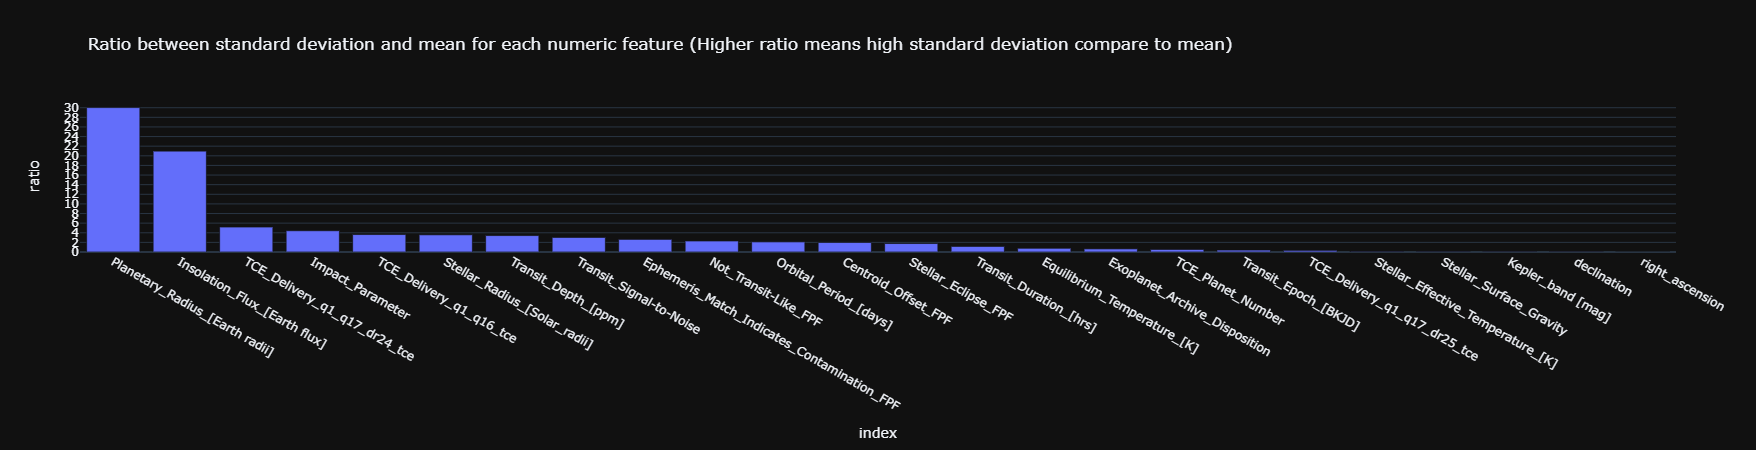

In [84]:
plot_Variance = px.bar(stats_df, y='ratio', title = "Ratio between standard deviation and mean for each numeric feature\n(Higher ratio means high standard deviation compare to mean)")

plot_Variance.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        dtick = 2
    ),
    template="plotly_dark"
)

plot_Variance.show()

### Covariance Matrix - (long runtime)

In [24]:
#covMatrix = np.cov(keplerProcessed_df,bias=True)

#fig_covMatrix = px.imshow(covMatrix)
#fig_covMatrix.show()

### Correlation Matrix

In [25]:
keplerCorrMatrix = keplerProcessed_df.corr()
#print(keplerCorrMatrix) 

In [26]:
np.tril(np.ones(keplerCorrMatrix.shape)).astype(np.bool)[0:5,0:5]

array([[ True, False, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True]])

In [27]:
lowerTriangeCorr = keplerCorrMatrix.where(np.tril(np.ones(keplerCorrMatrix.shape)).astype(np.bool))

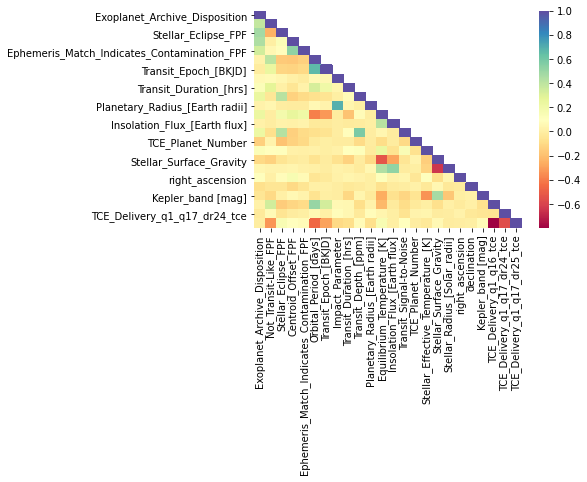

In [28]:
hmap=sn.heatmap(lowerTriangeCorr,cmap="Spectral")

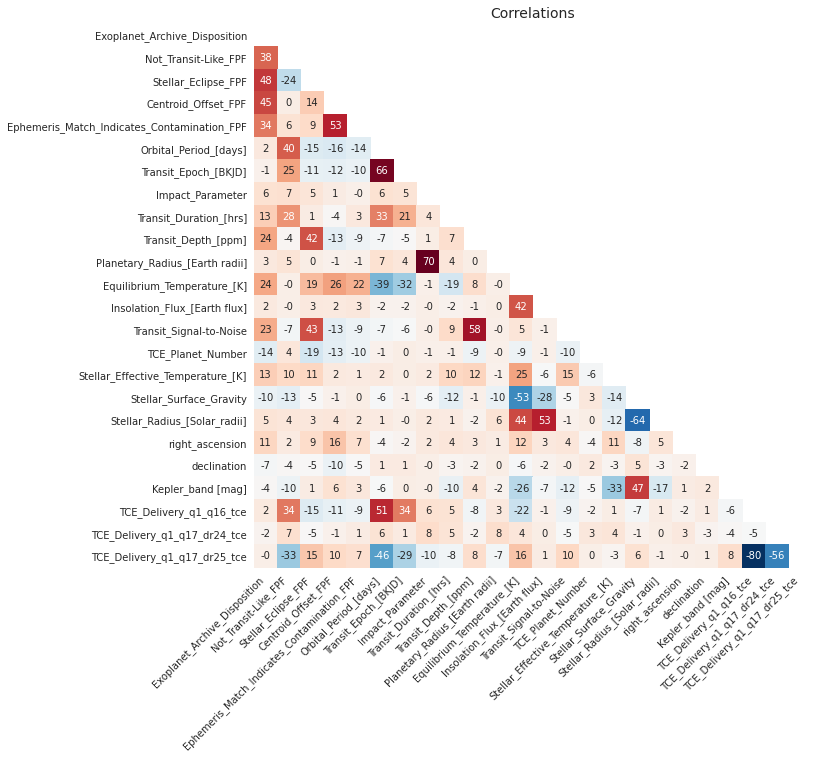

In [29]:
 # Generate a mask for the upper triangle
corr_mask = np.zeros_like(keplerCorrMatrix)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(10,10))

# Plot heatmap of annotated correlations; change background to white
# uses seaborn
with sn.axes_style('white'):
    sn.heatmap(keplerCorrMatrix*100, 
                cmap='RdBu_r', 
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)
    
plt.title('Correlations', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45, horizontalalignment='right')
#plt.xticks(rotation=45)
plt.show()

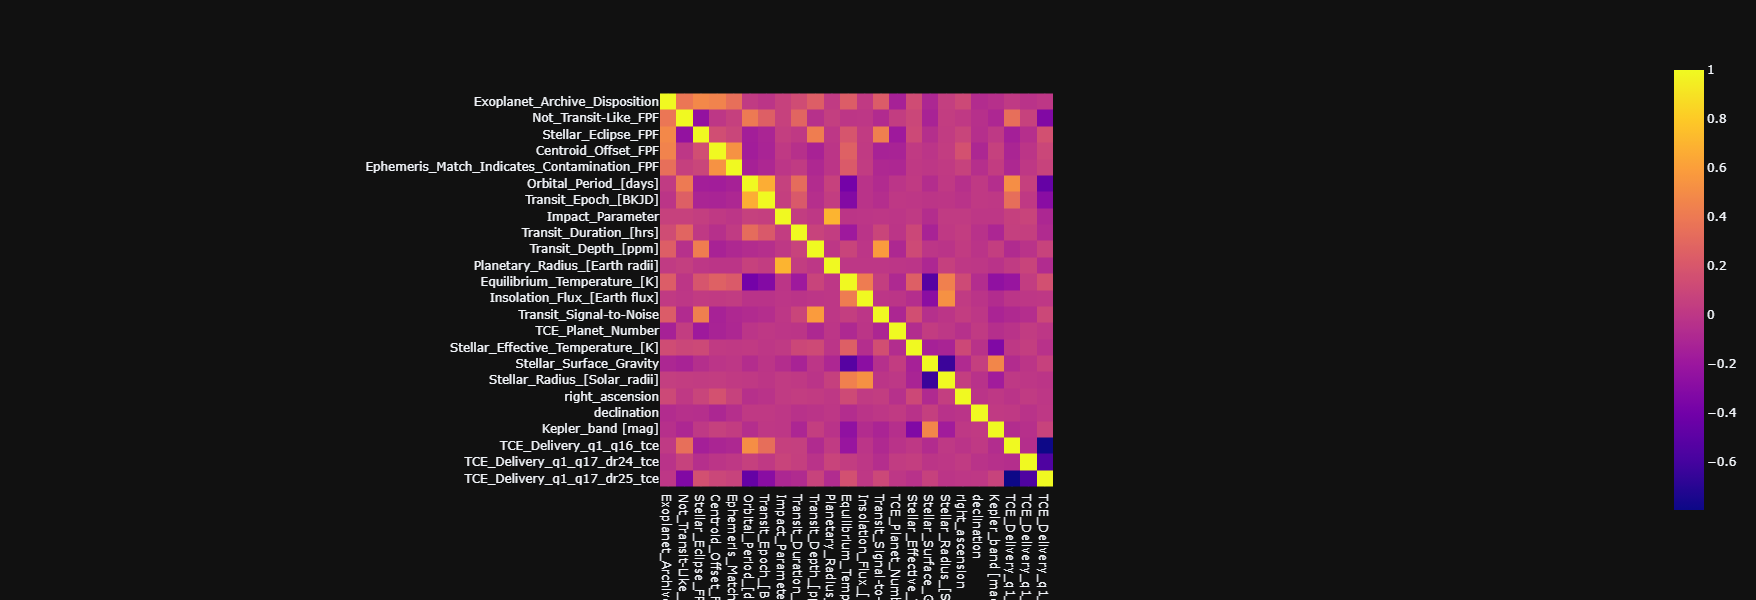

In [88]:
fig_corrMatrix = px.imshow(keplerCorrMatrix, width=800, height=600)
fig_corrMatrix.update_yaxes(automargin=True)
fig_corrMatrix.update_layout(template="plotly_dark")
fig_corrMatrix.show()

In [31]:
# Correlation matrix on selected features
keplerCorrMatrix = keplerProcessed_df.corr()

### Feature histogram grid

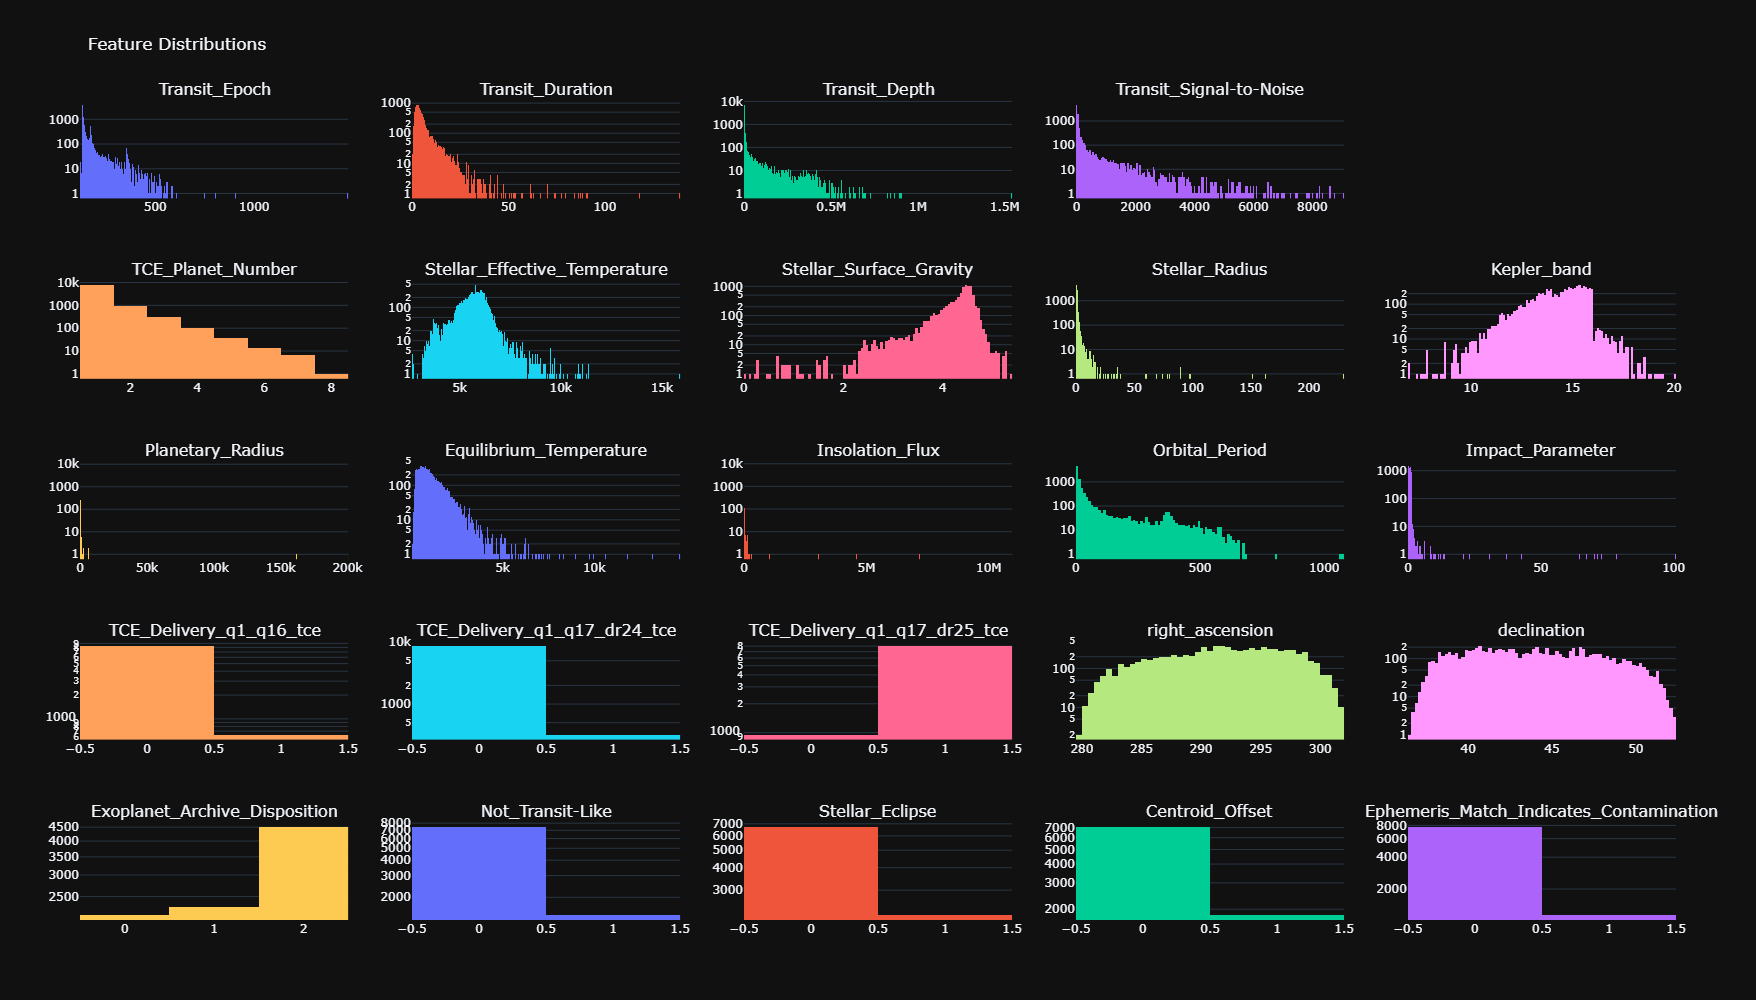

In [82]:
# Plotly feature histogram grid
# Done individually to customize traces as needed
# All binary features will be refactored to bar graphs - PENDING

plot_histGrid = make_subplots(
    rows=5, cols=5, subplot_titles=("Transit_Epoch",
                                    "Transit_Duration",
                                    "Transit_Depth",
                                    "Transit_Signal-to-Noise",
                                    "",
                                    "TCE_Planet_Number",
                                    "Stellar_Effective_Temperature",
                                    "Stellar_Surface_Gravity",
                                    "Stellar_Radius",
                                    "Kepler_band",
                                    "Planetary_Radius",
                                    "Equilibrium_Temperature",
                                    "Insolation_Flux",
                                    "Orbital_Period",
                                    "Impact_Parameter",
                                    "TCE_Delivery_q1_q16_tce",
                                    "TCE_Delivery_q1_q17_dr24_tce",
                                    "TCE_Delivery_q1_q17_dr25_tce",
                                    "right_ascension",
                                    "declination",
                                    "Exoplanet_Archive_Disposition",
                                    "Not_Transit-Like",
                                    "Stellar_Eclipse",
                                    "Centroid_Offset",
                                    "Ephemeris_Match_Indicates_Contamination"
                                   )
)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Transit_Epoch_[BKJD]"]),
                           row=1, col=1)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Transit_Duration_[hrs]"]),
                           row=1, col=2)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Transit_Depth_[ppm]"]),
                           row=1, col=3)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Transit_Signal-to-Noise"]),
                           row=1, col=4)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["TCE_Planet_Number"]),
                           row=2, col=1)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Stellar_Effective_Temperature_[K]"]),
                           row=2, col=2)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Stellar_Surface_Gravity"]),
                           row=2, col=3)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Stellar_Radius_[Solar_radii]"]),
                           row=2, col=4)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Kepler_band [mag]"]),
                           row=2, col=5)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Planetary_Radius_[Earth radii]"]),
                           row=3, col=1)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Equilibrium_Temperature_[K]"]),
                           row=3, col=2)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Insolation_Flux_[Earth flux]"]),
                           row=3, col=3)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Orbital_Period_[days]"]),
                           row=3, col=4)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Impact_Parameter"]),
                           row=3, col=5)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["TCE_Delivery_q1_q16_tce"]),
                           row=4, col=1)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["TCE_Delivery_q1_q17_dr24_tce"]),
                           row=4, col=2)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["TCE_Delivery_q1_q17_dr25_tce"]),
                           row=4, col=3)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["right_ascension"]),
                           row=4, col=4)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["declination"]),
                           row=4, col=5)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Exoplanet_Archive_Disposition"]),
                           row=5, col=1)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Not_Transit-Like_FPF"]),
                           row=5, col=2)

#bar graph version
#plot_histGrid.append_trace(go.Bar(x=keplerProcessed_df["Not_Transit-Like_FPF"], y=keplerProcessed_df["Not_Transit-Like_FPF"].value_counts()), row=5, col=2)


plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Stellar_Eclipse_FPF"]),
                           row=5, col=3)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Centroid_Offset_FPF"]),
                           row=5, col=4)

plot_histGrid.append_trace(go.Histogram(x=keplerProcessed_df["Ephemeris_Match_Indicates_Contamination_FPF"]),
                           row=5, col=5)


plot_histGrid.update_layout(height=1000, width=1500,
                            title_text="Feature Distributions",
                            showlegend=False,
                            template="plotly_dark"
                           )

plot_histGrid.update_yaxes(type="log")


plot_histGrid.show()


### Feature selection
Code is in raw cells due to long runtime

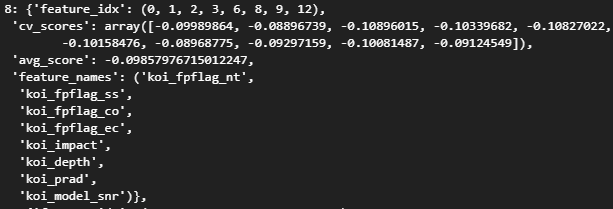

After extensive testing it has been revealed that reducing the features does significantly change the f1 scores of the models. Therefore the models are ran on all features
- feature evaluation used: correlation matrices,plot of the coefficients, and sequential feature analysis (uses mlxtend library) 
- Features with importance close to 0 have minimal impact 
- Removing features with a score <1 actually decreased the f1 scores
- PCA not used aid understandability and we do not have a large number of features

In [33]:
keplerProcessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8945 entries, K00752.01 to K07989.01
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Exoplanet_Archive_Disposition                8945 non-null   int32  
 1   Not_Transit-Like_FPF                         8945 non-null   int64  
 2   Stellar_Eclipse_FPF                          8945 non-null   int64  
 3   Centroid_Offset_FPF                          8945 non-null   int64  
 4   Ephemeris_Match_Indicates_Contamination_FPF  8945 non-null   int64  
 5   Orbital_Period_[days]                        8945 non-null   float64
 6   Transit_Epoch_[BKJD]                         8945 non-null   float64
 7   Impact_Parameter                             8945 non-null   float64
 8   Transit_Duration_[hrs]                       8945 non-null   float64
 9   Transit_Depth_[ppm]                          8945 non-null   float

# <span style="color:slateblue"><b>Visualizations

In [34]:
# Create dataframes for each disposition. Will be used in the plotly traces
kepler_confirmed = kepler_clean_full[kepler_clean_full['Exoplanet_Archive_Disposition'] == "CONFIRMED"]
kepler_candidates = kepler_clean_full[kepler_clean_full['Exoplanet_Archive_Disposition'] == "CANDIDATE"]
kepler_falsepositive = kepler_clean_full[kepler_clean_full['Exoplanet_Archive_Disposition'] == "FALSE POSITIVE"]

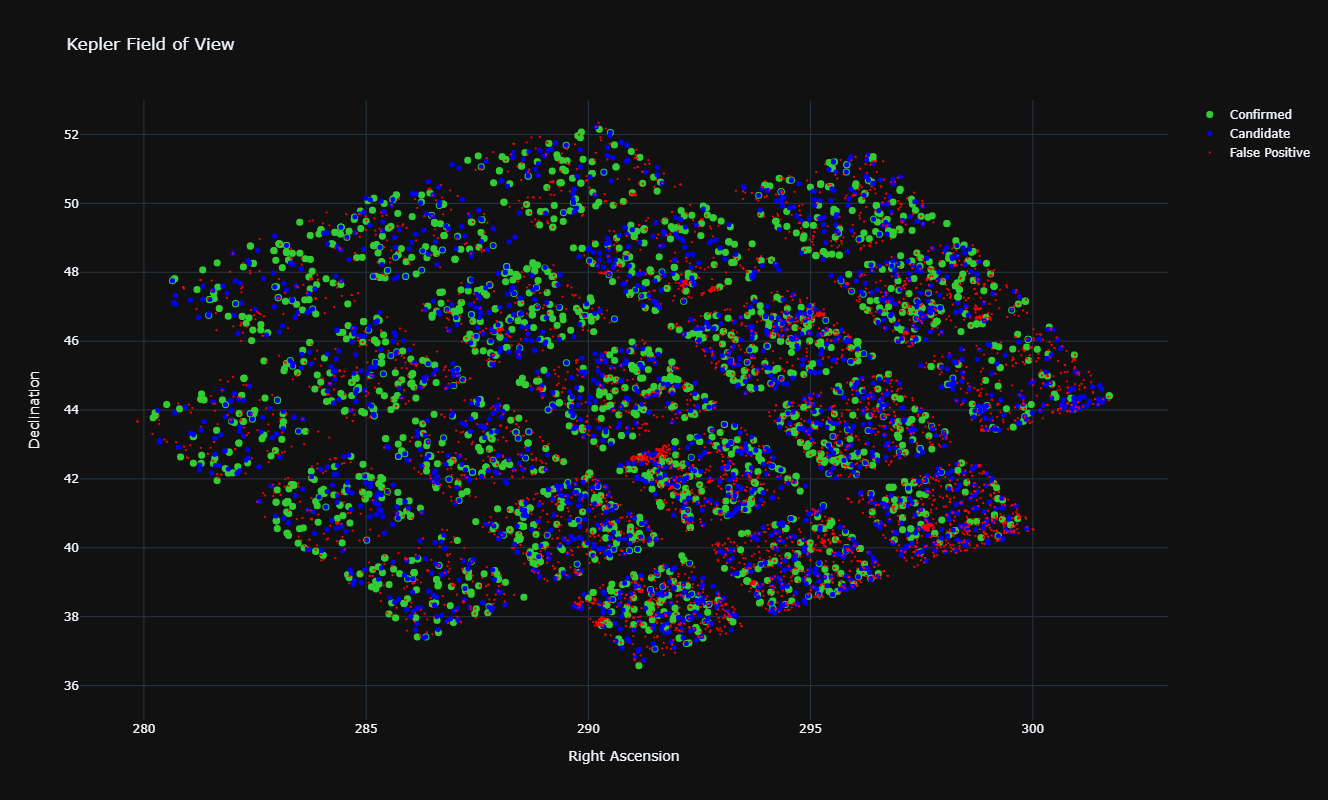

In [35]:
# Plot Kepler field of view. Colors denote disposition
plot_FOV = go.Figure()

# 1st trace for CONFIRMED exoplanets
plot_FOV.add_trace(
    go.Scatter(
        x=kepler_confirmed["right_ascension"],
        y=kepler_confirmed["declination"],
        showlegend=True,
        name = "Confirmed",
        mode = "markers",
        marker=dict(
            size=7,
            color = "limegreen"
        ),
        text = kepler_confirmed['Exoplanet_Archive_Disposition'],
        hovertemplate = "<b>%{text}<b><br><br>" + "Orbital_Period_[days]: %{x}<br>" + "Planetary_Radius_[Earth radii]: %{y}<br>" + "<extra></extra>",

    )
)

# 2nd trace for CANDIDATE exoplanets
plot_FOV.add_trace(
    go.Scatter(
        x=kepler_candidates["right_ascension"],
        y=kepler_candidates["declination"],
        showlegend=True,
        name = "Candidate",
        mode = "markers",
        marker=dict(
            size=5,
            color="blue"
        ),
        text = kepler_candidates['Exoplanet_Archive_Disposition'],
        hovertemplate = "<b>%{text}<b><br><br>" + "Orbital_Period_[days]: %{x}<br>" + "Planetary_Radius_[Earth radii]: %{y}<br>" + "<extra></extra>",
    )
)

# 3rd trace for False positives
plot_FOV.add_trace(
    go.Scatter(
        x=kepler_falsepositive["right_ascension"],
        y=kepler_falsepositive["declination"],
        showlegend=True,
        name = "False Positive",
        mode = "markers",
        marker=dict(
            size=2,
            color="red"
        ),
        text = kepler_falsepositive['Exoplanet_Archive_Disposition'],
        hovertemplate = "<b>%{text}<b><br><br>" + "Orbital_Period_[days]: %{x}<br>" + "Planetary_Radius_[Earth radii]: %{y}<br>" + "<extra></extra>",
    )
)

plot_FOV.update_xaxes(title_text = "Right Ascension")
plot_FOV.update_yaxes(title_text = "Declination", range=[35,53])

plot_FOV.update_layout(
    title="Kepler Field of View",
    template="plotly_dark",
    width=1000, height=800,

)

plot_FOV.show()

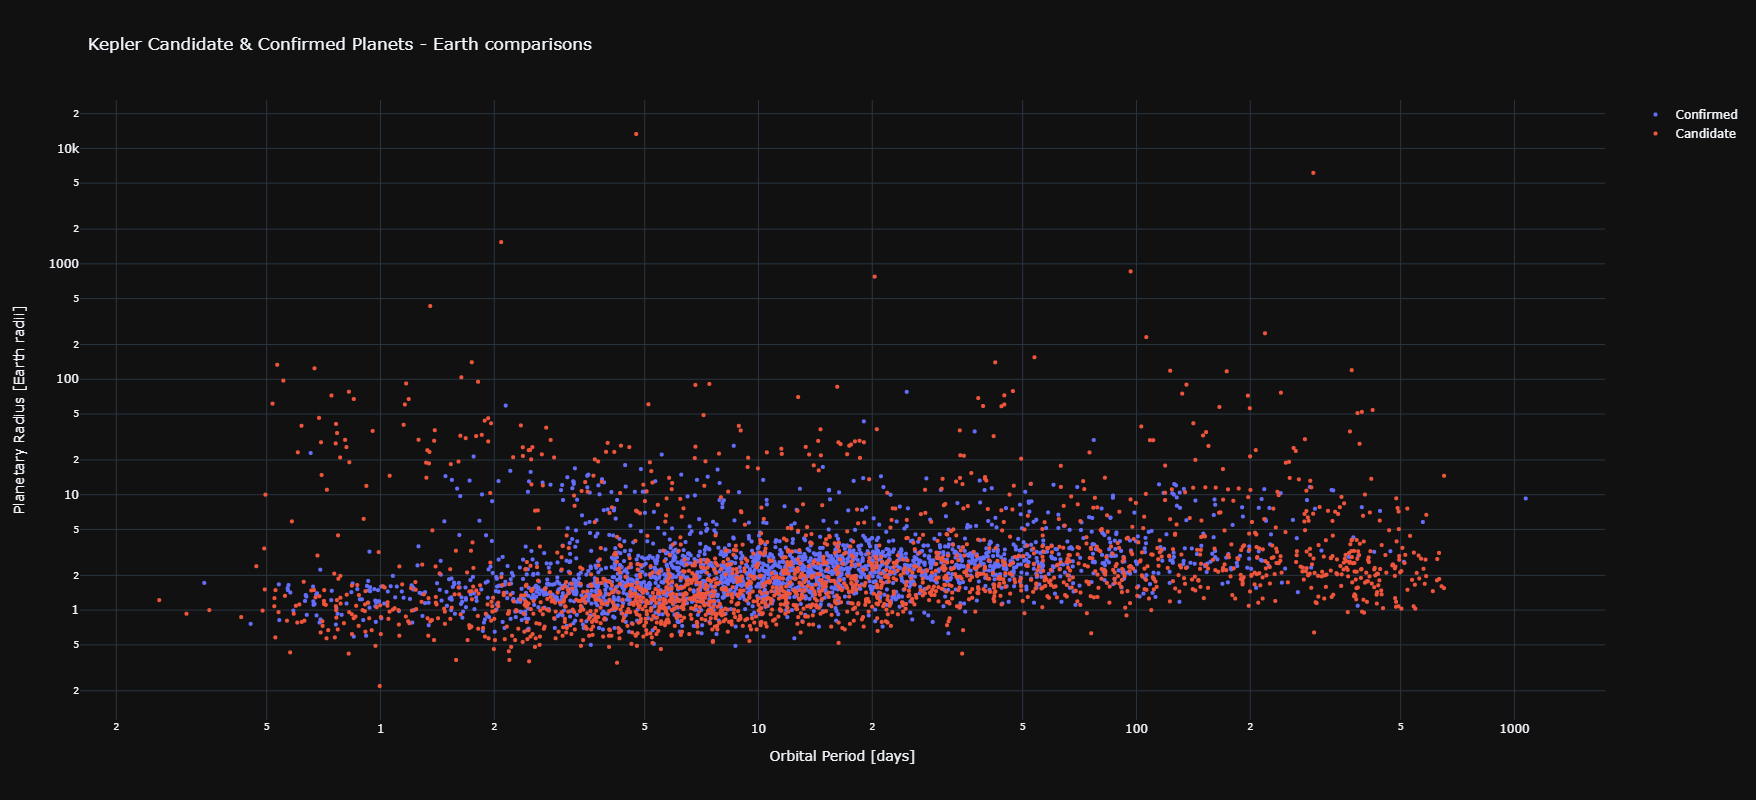

In [36]:
plot_radii = go.Figure()

# 1st trace for CONFIRMED exoplanets
plot_radii.add_trace(
    go.Scatter(
        x=kepler_confirmed["Orbital_Period_[days]"],
        y=kepler_confirmed["Planetary_Radius_[Earth radii]"],
        showlegend=True,
        name = "Confirmed",
        mode = "markers",
        marker=dict(
            size=4,
            colorscale="Tealgrn"
        ),
        
    )
)

# 2nd trace for CANDIDATE exoplanets
plot_radii.add_trace(
    go.Scatter(
        x=kepler_candidates["Orbital_Period_[days]"],
        y=kepler_candidates["Planetary_Radius_[Earth radii]"],
        showlegend=True,
        name = "Candidate",
        mode = "markers",
        marker=dict(
            size=4,
            colorscale="Sunsetdark"
        ),
    )
)


plot_radii.update_xaxes(type="log", title_text = "Orbital Period [days]")
plot_radii.update_yaxes(type="log", title_text = "Planetary Radius [Earth radii]")

plot_radii.update_layout(
    title="Kepler Candidate & Confirmed Planets - Earth comparisons",
    template="plotly_dark",
    width=1000, height=800,
)

plot_radii.show()

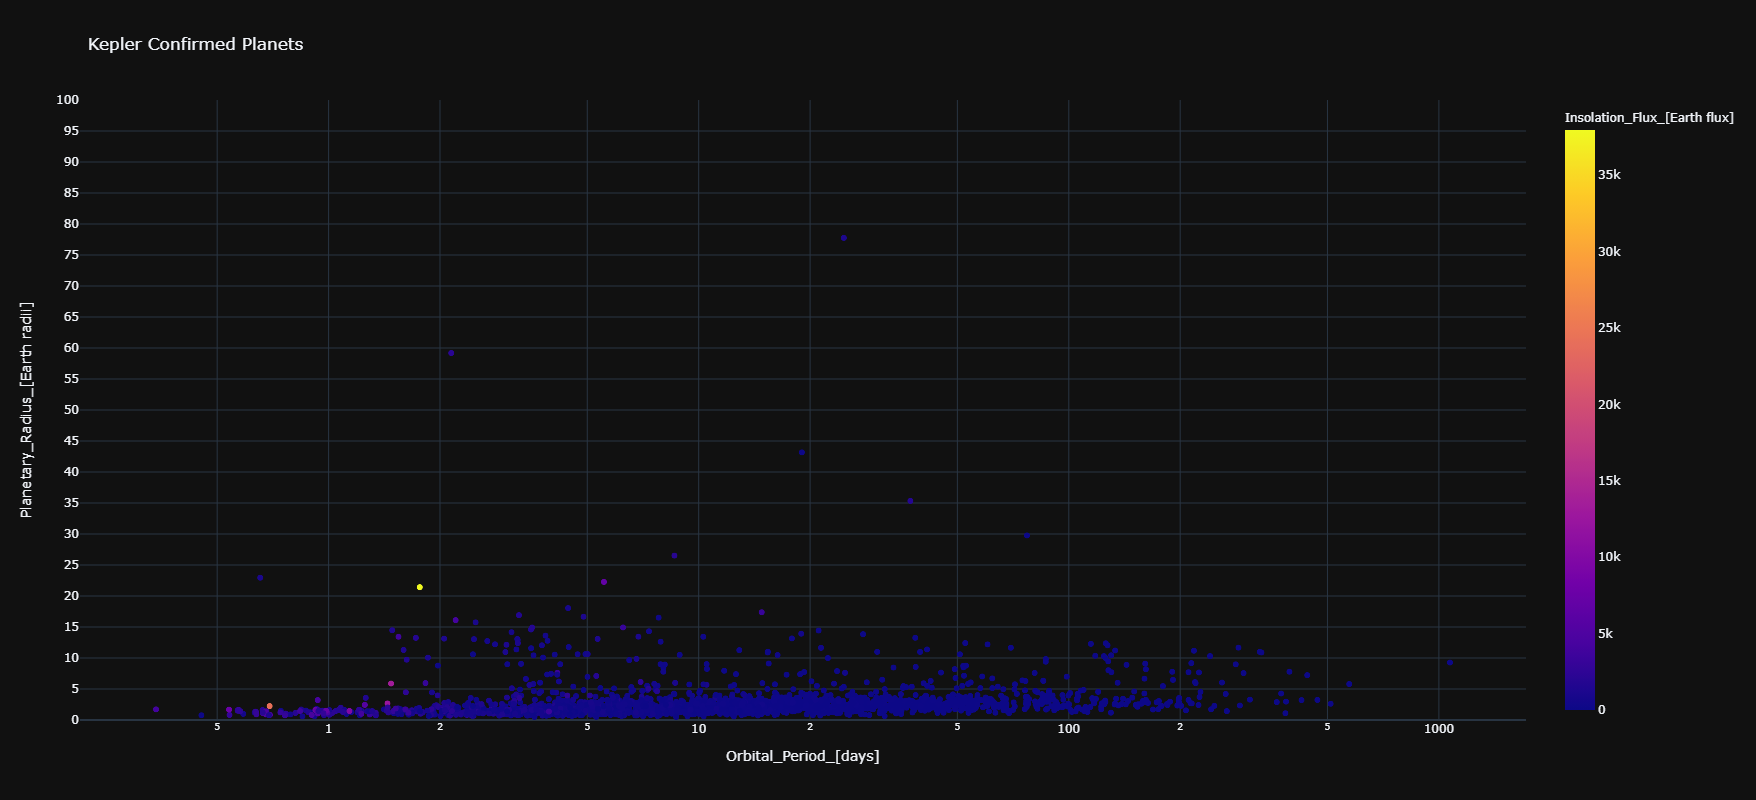

In [37]:


plot_radii = px.scatter(kepler_confirmed,
                        x="Orbital_Period_[days]", 
                        y="Planetary_Radius_[Earth radii]", 
                        template="plotly_dark",
                        width=1000, height=800,
                        log_x=True,
                        title = "Kepler Confirmed Planets",
                        color = "Insolation_Flux_[Earth flux]",
                       )
plot_radii.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 5,
    )
)


plot_radii.update_yaxes(range=[0, 100])


plot_radii.show()

# <span style="color:red"><b> Sequential Feature Selection results

### True

### FALSE

### using disposition instead of pdisposition